# Problem 1 - iLQR

Start creating symbolic linearized dynamics
Finished creating symbolic linearized dynamics after 2.6 seconds
Iteration: 0, Cost: 354.09494896378123, Previous Cost: 13206.64309052387
Finished creating symbolic linearized dynamics after 2.6 seconds
Iteration: 0, Cost: 354.09494896378123, Previous Cost: 13206.64309052387
Iteration: 1, Cost: 251.9890114107452, Previous Cost: 354.09494896378123
Iteration: 2, Cost: 196.74948537071253, Previous Cost: 251.9890114107452
Iteration: 1, Cost: 251.9890114107452, Previous Cost: 354.09494896378123
Iteration: 2, Cost: 196.74948537071253, Previous Cost: 251.9890114107452
Iteration: 3, Cost: 168.88466914849005, Previous Cost: 196.74948537071253
Iteration: 4, Cost: 155.2880517999952, Previous Cost: 168.88466914849005
Iteration: 3, Cost: 168.88466914849005, Previous Cost: 196.74948537071253
Iteration: 4, Cost: 155.2880517999952, Previous Cost: 168.88466914849005
Iteration: 5, Cost: 143.7965529841735, Previous Cost: 155.2880517999952
Iteration: 6, Cost: 13

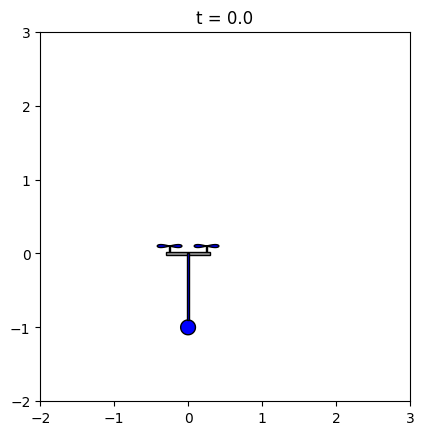

In [2]:
import numpy as np
import importlib
from iLQR import iLQR

import matplotlib.pyplot as plt

from quad_visualizer import Quadrotor2DWithPendulumVisualizer, create_animation
from IPython.display import HTML

quad_visualizer = Quadrotor2DWithPendulumVisualizer()


# Setup the iLQR problem
N = 200
dt = 0.02
x_goal = np.array([-0.5, 1.5, 0, np.pi, 0, 0, 0, 0])

# TODO: Adjust the costs as needed for convergence
Q = np.eye(8) * 1
Qf = 1e2 * np.eye(8)
R = 1e-3 * np.eye(2)

ilqr = iLQR(x_goal, N, dt, Q, R, Qf)

# Initial state at rest at the origin
x0 = np.zeros((8,))

# initial guess for the input is just hovering in place
u_guess = [0.5 * 9.81 * ilqr.m * np.ones((2,))] * (N-1)

x_sol, u_sol, K_sol = ilqr.calculate_optimal_trajectory(x0, u_guess)

# Visualize the solution
xx = np.array(x_sol)
ani = create_animation(quad_visualizer, xx.T, dt=0.02)
HTML(ani.to_html5_video())

# Problem 4 - Trajectory Optimization for a planar arm

## Start meshcat visualizer

Open the visualizer by clicking on the url in the output of this cell.

In [1]:
from pydrake.all import FindResourceOrThrow, StartMeshcat, MeshcatVisualizer
meshcat = StartMeshcat()


INFO:drake:Meshcat listening for connections at http://localhost:7000


## Compute the end effector (the ball) position and velocity using symbolic variables

This is how we get the expression in `kinematic_constraints.py`

## Run trajectory optimization to find the optimal trajectory

In [2]:
from find_swingup_trajectory import find_swingup_trajectory
from pydrake.geometry import Box, Rgba
from pydrake.math import RollPitchYaw, RigidTransform
import numpy as np

N = 5
initial_state = np.zeros(4)
final_configuration = np.array([np.pi, 0])
box_centers = np.array([[-1.5, 0.0],[1.5, 0.0]])
box_width = 2.0
box_height = 1.0
box = Box(box_width, 2.0, box_height)
color = Rgba(r=0.9, g=0.5, b=0.0, a=1.0)

meshcat.Delete('scene')
for i,b in enumerate(box_centers):
    box_tf = RigidTransform(RollPitchYaw([0,0,0]), [b[0], 0.0, b[1]])
    box_name = "box"+str(i)
    meshcat.SetObject("scene/"+box_name, box, color)
    meshcat.SetTransform("scene/"+box_name, box_tf)

x_traj, u_traj, prog, _, _, _ = find_swingup_trajectory(N, initial_state, final_configuration, box_centers, box_width, box_height)

optimal cost:  3.50607446026866
x_sol:  [[  0.           0.           0.           0.        ]
 [ -0.77669386   1.59076903  -4.02796731   8.61425305]
 [  0.19036744  -0.42823657   4.15016761  -8.17358875]
 [  1.65560239  -2.68853884  12.34459383  -0.37410213]
 [  3.14159265   0.         -11.18038546   9.39529771]]
u_sol:  [-3.33953937e+00  1.01182825e+00 -3.38954809e-01 -1.18825470e-03
  2.56998280e+00]
SolutionResult.kSolutionFound


## Visualize the optimal trajectory

This will animate the optimal trajectory in the meshcat window (see above)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import time

from pydrake.all import (
    DiagramBuilder, Simulator, FindResourceOrThrow, MultibodyPlant, PiecewisePolynomial, SceneGraph,
    Parser, MultibodyPositionToGeometryPose, TrajectorySource, Demultiplexer, ConstantVectorSource
)


# Create a MultibodyPlant for the arm
file_name = "acrobot.urdf"
builder = DiagramBuilder()
scene_graph = builder.AddSystem(SceneGraph())
acrobot = builder.AddSystem(MultibodyPlant(0.0))
acrobot.RegisterAsSourceForSceneGraph(scene_graph)
Parser(plant=acrobot).AddModels(file_name)
acrobot.Finalize()

n_q = acrobot.num_positions()
n_v = acrobot.num_velocities()
n_u = acrobot.num_actuators()


x_traj_source = builder.AddSystem(TrajectorySource(x_traj))
u_traj_source = builder.AddSystem(TrajectorySource(u_traj))

demux = builder.AddSystem(Demultiplexer(np.array([n_q, n_v])))
to_pose = builder.AddSystem(MultibodyPositionToGeometryPose(acrobot))
zero_inputs = builder.AddSystem(ConstantVectorSource(np.zeros(n_u)))

builder.Connect(zero_inputs.get_output_port(), acrobot.get_actuation_input_port())
builder.Connect(x_traj_source.get_output_port(), demux.get_input_port())
builder.Connect(demux.get_output_port(0), to_pose.get_input_port())
builder.Connect(to_pose.get_output_port(), scene_graph.get_source_pose_port(acrobot.get_source_id()))

MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

diagram = builder.Build()
diagram.set_name("diagram")


# Visualize the motion for `n_playback` times
n_playback = 3
for i in range(n_playback):
  # Set up a simulator to run this diagram.
  simulator = Simulator(diagram)
  simulator.Initialize()
  simulator.set_target_realtime_rate(1)
  simulator.AdvanceTo(8.0);
  time.sleep(.2)